# Customer Response Prediction for Promotional Offer
To achieve the main goal, we will train an XGBoost classification model in AWS Sagemaker. Using the hyperparameter tuning and logging functionalities available within AWS Sagemaker, we will be able to achieve best possible performance.

After deploying the endpoint, we can make inference on new dataset. Thereby using optimized XGBoost classification model to predict if a given customer will respond to a given promotional offer or not.

## 1. Libraries

Importing useful libraries

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    precision_recall_curve, roc_auc_score, cohen_kappa_score, roc_curve
)
import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
from sagemaker.sklearn import SKLearn
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner
from sagemaker.sklearn import SKLearnModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer, CSVSerializer
from sagemaker.deserializers import JSONDeserializer

## 2. Dataset

There are 3 available data sources provided in three JSON files as mentioned below. All the files were uploaded to AWS S3 bucket.
1. **profile.json**: Rewards program users;
2. **portfolio.json**: Offers sent during 30-day test period;
3. **transcript.json**: Event log which records user activity during test period

In [2]:
# Defining session, role and region which gives permission to interact with AWS services
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.boto_region_name
location_raw_dataset = "./raw-dataset"
bucket_name = "starbucks-capstone-project"

try:
    os.mkdir(location_raw_dataset)
except:
    pass

s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket_name)

for obj in my_bucket.objects.all():
    path, file = os.path.split(obj.key)
    if file and path=="raw-dataset":
        my_bucket.download_file(obj.key, os.path.join(location_raw_dataset, file))

In [3]:
# Reading raw data
portfolio = pd.read_json(os.path.join(location_raw_dataset, "portfolio.json"), lines=True)
profile = pd.read_json(os.path.join(location_raw_dataset, "profile.json"), lines=True)
transcript = pd.read_json(os.path.join(location_raw_dataset, "transcript.json"), lines=True)

Defining three functions which performs the following tasks:

* Firstly, processes the raw data into data that will feed the model
* Secondly, obtains label to the problem, that is if a given user will react to a promotional offer or not.
* Thirdly, performs feature engineering to enrich base dataset to obtain a better overall performance

In [4]:
def df_received_offer(transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Obtains label to our problem that is if a given user will react to a promotional offer or not

        Args: 
            transcript (pandas.DataFrame): event log dataset

        Returns: 
           pandas.DataFrame with every sent offer to a given customer and the final result (responded or not responded)
    """
    
    # Obtaining all offers received by customer
    offer_received = transcript.loc[transcript.event == "offer received", :]
    offer_received.loc[:, "offer"] = offer_received.loc[:, "value"].apply(lambda x: x["offer id"])
    offer_received = offer_received.loc[:, ["person", "offer", "time_in_days"]]

    offer_received = pd.merge(offer_received, portfolio.loc[:, ["id", "duration", "difficulty"]], how="inner",
                           left_on="offer", right_on="id")
    
    # Retrieving offers viewed while offer was active 
    offer_viewed = transcript.loc[transcript.event == "offer viewed", :]
    offer_viewed.loc[:, "offer"] = offer_viewed.loc[:, "value"].apply(lambda x: x["offer id"])

    offer_viewed = pd.merge(offer_received, offer_viewed, on=["person", "offer"], 
                         how="outer", suffixes=["_received", "_viewed"])

    offer_viewed = offer_viewed.loc[
    (offer_viewed.time_in_days_viewed > offer_viewed.time_in_days_received) &
    (offer_viewed.time_in_days_viewed - offer_viewed.time_in_days_received <= offer_viewed.duration), :]

    cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", "time_in_days_viewed"]
    offer_viewed = offer_viewed.loc[:, cols]
    
    # Obtaining completed informational offers for difficulty 0
    transaction_completed = transcript.loc[transcript.event == "transaction", ["person", "time_in_days"]]

    transaction_completed = pd.merge(offer_viewed, transaction_completed, on=["person"], suffixes=["_viewed", "_transaction_completed"],
                         how="outer")

    transaction_completed = (transaction_completed.loc[
        (transaction_completed.time_in_days > transaction_completed.time_in_days_viewed) &
        (transaction_completed.time_in_days - transaction_completed.time_in_days_received <= transaction_completed.time_in_days_received) &
        (transaction_completed.difficulty == 0), ["person", "offer", "time_in_days_received", "time_in_days"]]
                                  .groupby(["person", "offer", "time_in_days_received"])
                                  .first()
                                  .reset_index()
                                  .iloc[:, :-1]
    )
    
    # Obtaining completed offers for all other cases
    offer_completed = transcript.loc[transcript.event == "offer completed", :]
    offer_completed.loc[:, "offer"] = offer_completed.loc[:, "value"].apply(lambda x: x["offer_id"])

    offer_completed = pd.merge(offer_viewed, offer_completed, on=["person", "offer"], 
                            how="outer", suffixes=["_viewed", "_completed"])

    offer_completed = offer_completed.loc[
        (offer_completed.time_in_days > offer_completed.time_in_days_viewed) &
        (offer_completed.time_in_days - offer_completed.time_in_days_received <= offer_completed.duration) &
        (offer_completed.difficulty != 0), :]

    cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", 
        "time_in_days_viewed", "time_in_days"]
    offer_completed = offer_completed.loc[:, cols]
    
    # Appending all completed offers
    offer_successful = pd.concat(
        [
            offer_completed.loc[:, ["person", "offer", "time_in_days_received"]],
            transaction_completed.loc[:, ["person", "offer", "time_in_days_received"]]
        ],
        axis=0
    )
    offer_successful = offer_successful.drop_duplicates()
    offer_successful.loc[:, "responded_customer"] = 1
    
    # Creating final base dataset
    offer_received = offer_received.rename(columns={"time_in_days": "time_in_days_received"})

    df = pd.merge(
        offer_received.loc[:, ["person", "offer", "time_in_days_received"]],
        offer_successful,
        on=["person", "offer", "time_in_days_received"],
        how="left"
    )
    df = (df.sort_values(by=["person", "offer", "time_in_days_received"])
            .fillna(0)
         )
    df.loc[:, "responded_customer"] = df.loc[:, "responded_customer"].astype(int)
    
    return df

In [5]:
def df_feature_engg(base_df: pd.DataFrame, profile: pd.DataFrame,
                        portfolio: pd.DataFrame, transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Performs feature engineering to enrich base dataset

        Args:
            base_df (pandas.DataFrame): base dataframe with every sent offer to a given customer and the final result (responded or not responded)
            profile (pandas.DataFrame): rewards program users
            portfolio (pandas.DataFrame): offers available during 30-day test period
            transcript (pandas.DataFrame): event log dataset

        Returns: 
           pandas.DataFrame with features and target label used to train model
    """
    
    # Joining profile dataframe and base dataframe, then performing feature engineering
    df = pd.merge(left=base_df, right=profile, right_on="id", left_on="person", how="inner")
    df = df.drop(columns=["id"])
    df.loc[:, "period_of_membership"] = (
        (df.loc[:, "became_member_on"].max() - df.loc[:, "became_member_on"]).dt.days
    )

    df = df.drop(columns=["became_member_on"])
    df.loc[:, "gender"] = df.loc[:, "gender"].astype("category")
    
    # Joining portfolio dataframe and base dataframe, then performing feature engineering
    df = pd.merge(right=portfolio, right_on="id", left=df, how="inner", left_on="offer")
    df = df.drop(columns=["id"])
    channel_types = df.channels.explode().unique()
    for channel in channel_types:
        df.loc[:, channel] = df.loc[:, "channels"].apply(lambda x: channel in x).astype(int)
    df = df.drop(columns=["channels"])
    df.loc[:, "offer_type"] = df.loc[:, "offer_type"].astype("category")
    
    # Adding features of transcript dataframe
    info_transactions = transcript.loc[transcript.event == "transaction", ["person", "value", "time_in_days"]]
    info_transactions.loc[:, "amount"] = info_transactions.loc[:, "value"].apply(lambda x: x["amount"])
    info_transactions = info_transactions.drop(columns=["value"])
    
    df_key_columns = df.loc[:, ["person", "offer", "time_in_days_received"]]
    transactional_features = pd.merge(df_key_columns, info_transactions, how="left", on=["person"])
    transactional_features = (
        transactional_features.loc[(transactional_features.time_in_days < transactional_features.time_in_days_received), :]
    )
    transactional_features = (
        transactional_features.groupby(["person", "offer", "time_in_days_received"])
                           .agg({"amount": "mean", "time_in_days": "count"})
                           .reset_index()
                           .rename(columns={"amount": "average_purchase", "time_in_days": "frequency"})
    )
    df = pd.merge(df, transactional_features, how="left", on=["person", "offer", "time_in_days_received"])
    df.loc[:, "average_purchase"] = df.loc[:, "average_purchase"].fillna(0)
    df.loc[:, "frequency"] = df.loc[:, "frequency"].fillna(0)
    
    return df

In [6]:
def df_final(profile: pd.DataFrame, portfolio: pd.DataFrame, 
                        transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Processes raw data into data that will feed the model

        Args:
            profile (pandas.DataFrame): rewards program users
            portfolio (pandas.DataFrame): offers available during 30-day test period
            transcript (pandas.DataFrame): event log dataset

        Returns: 
           pandas.DataFrame with features and target label used to train the model
    """
    
    # First level of preprocessing applied for age, became_member_on and time features
    profile.loc[:, "age"] = profile.loc[:, "age"].apply(lambda x: np.nan if x==118 else x)
    profile.loc[:, "became_member_on"] = pd.to_datetime(
                                                profile.loc[:, "became_member_on"]
                                                          .astype(str)
                                                          .apply(lambda x: f"{x[-2:]}-{x[4:-2]}-{x[:4]}")
                                        )
    transcript.loc[:, "time_in_days"] = transcript.loc[:, "time"] / 24
    
    # Performs final tranformation
    base_df = df_received_offer(transcript)
    df = df_feature_engg(base_df, profile, portfolio, transcript)
    return df

Creating preprocessed and transformed dataset

In [7]:
df = df_final(profile, portfolio, transcript)
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership,reward,difficulty,duration,offer_type,web,email,mobile,social,average_purchase,frequency
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0,14.600000,4.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.666923,13.0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.469286,14.0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0,4.855000,2.0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0,6.803333,3.0


Here we split the dataset into train,validation and test sets

Since the same offer could be offered to a customer more than once, data redundancy must be taken care which may cause an overestimate of the final performance. Therefore, we will consider the pair offer-person when splitting the dataset. This process will help us to avoid overfitting. In order to do that, we will combine `person` and `offer` columns and then perform hashing. The datasets are split, by bucketizing the hashing result.

In [8]:
def df_split_train_val_test(df: pd.DataFrame, size_val: float = 0.2, size_test: float = 0.2, num_buckets: int = 10):
    """
    Splits dataset into training, validation and testing - performed hashing on user-offer pair

        Args:
            df (pandas.DataFrame): final dataframe containing features and target label
            num_buckets (int): number of buckets to hash the data
            size_val (float): fraction of the data that will be used for validation
            size_test (float): fraction of the data that will be used for testing

        Returns: 
           Tuple of pandas.DataFrame containing training, validation and testing set
    """
    df.loc[:, "hash_id"] = df.apply(lambda x: hash(x["person"]+x["offer"]) % num_buckets, axis=1)
    
    test_index = int(size_test * num_buckets)
    val_index = test_index + int(size_val * num_buckets)

    df_test = df.loc[df.hash_id < test_index, :]
    df_val = df.loc[(df.hash_id < val_index) & (df.hash_id >= test_index), :]
    df_train = df.loc[df.hash_id >= val_index, :]
    
    return (df_train, df_val, df_test)

In [9]:
df_train, df_val, df_test = df_split_train_val_test(df=df, size_val=0.2, size_test=0.2, num_buckets=10)
print(f"Validate train/validation/test size:\n")
print(f"Training set Size: {np.round(df_train.shape[0] / df.shape[0], 2)}")
print(f"Validation set Size: {np.round(df_val.shape[0] / df.shape[0], 2)}")
print(f"Testing set Size: {np.round(df_test.shape[0] / df.shape[0], 2)}")

Validate train/validation/test size:

Training set Size: 0.6
Validation set Size: 0.2
Testing set Size: 0.2


Finally, processed data is uploaded to the S3 Bucket accordingly, so that our Training Job is able to access it later on.

In [10]:
location_preprocessed_data = "./data-preprocessed"

try:
    os.mkdir(location_preprocessed_data)
    os.mkdir(os.path.join(location_preprocessed_data, "train"))
    os.mkdir(os.path.join(location_preprocessed_data, "test"))
except:
    pass

In [11]:
df_train.to_csv(os.path.join(location_preprocessed_data, "train", "train"), index=False)
df_train.to_csv(os.path.join(location_preprocessed_data, "train", "validation"), index=False)
df_train.to_csv(os.path.join(location_preprocessed_data, "test", "test"), index=False)

s3_data_path = session.upload_data(location_preprocessed_data, bucket=bucket_name)

## 3. Hyperparameter Tuning

This section deals with performing hyperparameter tuning. Hyperparameter tuning is choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a model argument whose value is set before the learning process begins. The key to machine learning algorithms is hyperparameter tuning which will help us to find a best performing model.

Below are the details of hyperparameters set:

### Preprocessing

* **resampling-ratio**: Defined a continuous value. When performing oversampling with Synthetic Minority Oversampling Technique, this hyperparameter is used to increase training performance.
* **numerical-imputation**: Used to impute missing numerical data. Defined as categorical value - mean, median
* **categorical-imputation**: Used to impute missing categorical data. Defined as categorical value - most_frequent, N/A

### XGBoost

* **xgboost-estimators**: Defined as integer value, it represents number of boosting rounds
* **xgboost-max-depth**: Defined as integer value, it represents maximum tree depth for base learners
* **xgboost-gamma**: Defined as continuous value, it represents minimum loss reduction required to make a further partition on a leaf node of the tree
* **xgboost-learning-rate**: Defined as continuous value, it represents learning rate used to adjust estimator outputs

In [12]:
hyperparameter_ranges = {
    "resampling-ratio": ContinuousParameter(0.8, 1.0),
    "numerical-imputation": CategoricalParameter(["mean", "median"]),
    "categorical-imputation": CategoricalParameter(["most_frequent", "N/A"]),
    "xgboost-estimators": IntegerParameter(50, 200),
    "xgboost-max-depth": IntegerParameter(7, 10),
    "xgboost-gamma": ContinuousParameter(0.0, 4.0),
    "xgboost-learning-rate": ContinuousParameter(0.01, 0.3, scaling_type="Logarithmic"),
}

In [13]:
estimator = SKLearn(
    source_dir="./hpo-xgboost",
    entry_point="hpo.py",
    base_job_name="starbucks-capstone-project_job",
    framework_version='0.23-1',
    py_version="py3",
    role=role,
    instance_type="ml.m5.large",
    instance_count=1
)

F1-score metric can be interpreted as the weighted average of precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0. Our goal here is to obtain a **maximum** F1-score

In [14]:
objective_metric_name = "val_f1_score"
objective_type = "Maximize"
metric_definitions = [{
    "Name": objective_metric_name,
    "Regex": "F1-SCORE = ([0-9\\.]+)"
}]

In [15]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    strategy='Random',
    max_jobs=20,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [16]:
tuner.fit({
    "train": os.path.join(s3_data_path, "train")
})

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Reviewing the best hyperparameters:

In [17]:
best_hyperparameters = tuner.best_estimator().hyperparameters()
best_hyperparameters


2022-01-19 01:03:36 Starting - Preparing the instances for training
2022-01-19 01:03:36 Downloading - Downloading input data
2022-01-19 01:03:36 Training - Training image download completed. Training in progress.
2022-01-19 01:03:36 Uploading - Uploading generated training model
2022-01-19 01:03:36 Completed - Training job completed


{'_tuning_objective_metric': '"val_f1_score"',
 'categorical-imputation': '"N/A"',
 'numerical-imputation': '"mean"',
 'resampling-ratio': '0.9671111857331107',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"SKLearn"',
 'sagemaker_estimator_module': '"sagemaker.sklearn.estimator"',
 'sagemaker_job_name': '"starbucks-capstone-project_job-2022-01-19-00-41-45-933"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-956692068952/starbucks-capstone-project_job-2022-01-19-00-41-45-933/source/sourcedir.tar.gz"',
 'xgboost-estimators': '96',
 'xgboost-gamma': '1.630531290749495',
 'xgboost-learning-rate': '0.23454914692146572',
 'xgboost-max-depth': '9'}

## 4. Final Model Training using the Best Hyperparameters
This section deals with training final model using the best hyperparameters. The evaluation is performed on test dataset which was not used during hyperparameter tuning stage at all.

In [18]:
hyperparameters = {
    "resampling-ratio": best_hyperparameters["resampling-ratio"],
    "numerical-imputation": best_hyperparameters["numerical-imputation"].strip('"'),
    "categorical-imputation": best_hyperparameters["categorical-imputation"].strip('"'),
    "xgboost-estimators": best_hyperparameters["xgboost-estimators"],
    "xgboost-max-depth": best_hyperparameters["xgboost-max-depth"],
    "xgboost-gamma": best_hyperparameters["xgboost-gamma"],
    "xgboost-learning-rate": best_hyperparameters["xgboost-learning-rate"],
}

In [19]:
estimator = SKLearn(
    source_dir="./best-hpo-model-training",
    entry_point="model_training.py",
    base_job_name="starbucks-capstone-project-best-hpo-training",
    framework_version='0.23-1',
    py_version="py3",
    role=role,
    hyperparameters=hyperparameters,
    instance_type="ml.m5.large",
    instance_count=1
)

In [20]:
estimator.fit({
    "train": os.path.join(s3_data_path, "train"),
    "test": os.path.join(s3_data_path, "test")
})

2022-01-19 01:39:33 Starting - Starting the training job...
2022-01-19 01:40:04 Starting - Launching requested ML instancesProfilerReport-1642556372: InProgress
......
2022-01-19 01:41:04 Starting - Preparing the instances for training.........
2022-01-19 01:42:25 Downloading - Downloading input data...
2022-01-19 01:43:05 Training - Downloading the training image..2022-01-19 01:43:17,201 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-01-19 01:43:17,204 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-19 01:43:17,214 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-01-19 01:43:17,577 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt

2022-01-19 01:43:25 Training - Training image download completed. Training in progress.Requirement already satisfied: joblib>=0.11 in /miniconda3/li

In [21]:
model_data = estimator.model_data

In [22]:
model_data

's3://sagemaker-us-east-1-956692068952/starbucks-capstone-project-best-hpo-tra-2022-01-19-01-39-32-648/output/model.tar.gz'

## 5. Model Deployment

In [23]:
json_serializer = JSONSerializer()
csv_serializer = CSVSerializer()
json_deserializer = JSONDeserializer()


class ResponsePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ResponsePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=csv_serializer,
            deserializer=json_deserializer,
        )

inference_model = SKLearnModel(
    model_data=model_data,
    source_dir="./endpoint-serving",
    entry_point='endpoint.py',
    framework_version="0.23-1",
    py_version="py3",
    role=role,
    predictor_cls=ResponsePredictor
)

In [24]:
predictor = inference_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [25]:
predictor.endpoint_name

'sagemaker-scikit-learn-2022-01-19-01-45-49-484'

Testing inference with a JSON as input:

In [26]:
json_input = df_test.iloc[100, :].to_json()

In [27]:
response = predictor.predict(json_input, initial_args={"ContentType": "application/json"})
response

{'response_probability': [0.27522242069244385]}

Testing inference with a CSV as input:

In [28]:
csv_input = df_test.to_csv(line_terminator="\r\n", index=False)

In [29]:
response = predictor.predict(csv_input, initial_args={"ContentType": "text/csv"})
response

{'response_probability': [0.3297354578971863,
  0.21075646579265594,
  0.031141817569732666,
  0.14949029684066772,
  0.029957136139273643,
  0.5173438787460327,
  0.5067604780197144,
  0.416925847530365,
  0.11142026633024216,
  0.49640363454818726,
  0.49640363454818726,
  0.3580716550350189,
  0.33161595463752747,
  0.32262200117111206,
  0.0562744177877903,
  0.5027948021888733,
  0.06793294847011566,
  0.01611464098095894,
  0.052194930613040924,
  0.4210456907749176,
  0.09159378707408905,
  0.09159378707408905,
  0.45583370327949524,
  0.5054215788841248,
  0.5405545830726624,
  0.6338450312614441,
  0.2205331027507782,
  0.15926013886928558,
  0.25387388467788696,
  0.024214865639805794,
  0.4111224412918091,
  0.4574737250804901,
  0.1216588020324707,
  0.3409407436847687,
  0.09601127356290817,
  0.30948036909103394,
  0.11053009331226349,
  0.31084391474723816,
  0.4177105128765106,
  0.5025600790977478,
  0.2739502787590027,
  0.07884679734706879,
  0.36014845967292786,
  0

## 6. Analyzing the Model Performance

To estimate the performance of our model in a real world scenario, we can evaluate the model performance on a dataset which the model has not seen before that is the **test** dataset

In [30]:
THRESHOLD_VAL = 0.5

df_test.loc[:, "response_probability"] = response["response_probability"]
df_test.loc[:, "response_prediction"] = (df_test.loc[:, "response_probability"] > THRESHOLD_VAL).astype(int)
df_test.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,period_of_membership,reward,difficulty,...,offer_type,web,email,mobile,social,average_purchase,frequency,hash_id,response_probability,response_prediction
7,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,0.0,0,M,26.0,61000.0,1447,2,10,...,discount,1,1,1,0,0.000000,0.0,1,0.329735,0
8,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,21.0,1,M,26.0,61000.0,1447,2,10,...,discount,1,1,1,0,3.224444,9.0,1,0.210756,0
10,0092a132ead946ceb30d11a1ed513d20,2906b810c7d4411798c6938adc9daaa5,24.0,0,NaN,NaN,NaN,305,2,10,...,discount,1,1,1,0,0.846667,3.0,0,0.031142,0
13,009d10c2c38a4fd795a7bc6ddbbddb78,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,163,2,10,...,discount,1,1,1,0,1.951667,6.0,1,0.149490,0
16,00b5fb9d842d437e83033ad9e36f7148,2906b810c7d4411798c6938adc9daaa5,17.0,0,NaN,NaN,NaN,314,2,10,...,discount,1,1,1,0,0.000000,0.0,0,0.029957,0


In [31]:
def retrieve_classification_metric(classification_metric_name: str):
    """
    Retrieves method according to classification metric name

        Args: 
            classification_metric_name (str): a valid classification metric name
        Returns: 
           Method that accepts `y_true` and `y_pred`/`y_pred` to compute metric value
    """
    if classification_metric_name == "ACCURACY":
        return accuracy_score
    elif classification_metric_name == "RECALL":
        return recall_score
    elif classification_metric_name == "PRECISION":
        return precision_score
    elif classification_metric_name == "F1-SCORE":
        return f1_score
    elif classification_metric_name == "ROC-AUC":
        return roc_auc_score
    elif classification_metric_name == "COHEN-KAPPA":
        return cohen_kappa_score
    else:
        raise ValueError(f"No metric available in the name {classification_metric_name}.")

In [32]:
def model_performance_evaluate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Evaluates inferece pipeline performance on a dataset.Bootstrapping (20 trials) is applied to generate 
    confidence intervals for metrics.

        Args: 
            df (pandas.DataFrame): dataframe containing data

        Returns: 
           Pandas DataFrame containing metrics and the corresponding confidence interval.
    """
    num_experiments = 20
    confidence = 0.95
    
    metrics_dict = {
        "ACCURACY": [],
        "F1-SCORE": [],
        "PRECISION": [],
        "RECALL": [],
        "ROC-AUC": [],
        "COHEN-KAPPA": []
    }

    for _ in range(num_experiments):
        df_bootstrap = df.sample(frac=1.0, replace=True)
        y_true = df_bootstrap.loc[:, "responded_customer"].values
        y_pred = df_bootstrap.loc[:, "response_prediction"].values
        y_proba = df_bootstrap.loc[:, "response_probability"].values
        

        for key in metrics_dict.keys():
            if key == "ROC-AUC":
                metrics_dict[key].append(retrieve_classification_metric(key)(y_true, y_proba))
            else:
                metrics_dict[key].append(retrieve_classification_metric(key)(y_true, y_pred))

    results_output = {}
    for key, value in metrics_dict.items(): 
        lower, upper = st.t.interval(confidence, num_experiments-1, loc=np.mean(value), scale=st.sem(value))
        avg_value = np.round((lower + upper) / 2, 4)
        delta = np.round(upper - avg_value, 4)
        results_output[key] = f"{avg_value} ± {delta}"

    return pd.DataFrame([results_output])

In [33]:
model_performance_evaluate(df_test)

,ACCURACY,F1-SCORE,PRECISION,RECALL,ROC-AUC,COHEN-KAPPA
0,0.6931 ± 0.0019,0.4517 ± 0.0035,0.4432 ± 0.0038,0.4607 ± 0.0042,0.7088 ± 0.0022,0.2388 ± 0.0043


In [34]:
def __plot_pr(y_test, y_proba, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    ax.plot(recall, precision, color="red", label=f"PR")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.001))
    ax.legend(loc=4)
    ax.set_title("Precision-Recall Analysis", fontsize=13)
    
def __plot_cap(y_test, y_proba, ax):
    cap_df = pd.DataFrame(data=y_test, index=y_test.index)
    cap_df["Probability"] = y_proba

    total = cap_df.iloc[:, 0].sum()
    perfect_model = (cap_df.iloc[:, 0].sort_values(ascending=False).cumsum()/total).values
    current_model = (cap_df.sort_values(by="Probability", ascending=False).iloc[:, 0].cumsum()/total).values

    max_area = 0
    covered_area = 0
    h = 1/len(perfect_model)
    random = np.linspace(0, 1, len(perfect_model))
    for i, (am, ap) in enumerate(zip(current_model, perfect_model)):
        try:
            max_area += (ap-random[i]+perfect_model[i+1]-random[i+1])*h/2
            covered_area += (am-random[i]+current_model[i+1]-random[i+1])*h/2
        except:
            continue
    accuracy_ratio = covered_area/max_area

    ax.plot(np.linspace(0, 1, len(current_model)), current_model, 
                        color="green", label=f"AR = {accuracy_ratio:.3f}")
    ax.plot(np.linspace(0, 1, len(perfect_model)), perfect_model, color="red", label="Perfect Model")
    ax.plot([0,1], [0,1], color="navy")
    ax.set_xlabel("Individuals", fontsize=12)
    ax.set_ylabel("Target Individuals", fontsize=12)
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1.01))
    ax.legend(loc=4, fontsize=10)
    ax.set_title("CAP Analysis", fontsize=13)

def __plot_roc(y_test, y_proba, ax):
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    ax.plot(fpr, tpr, color="red", label=f"(AUC = {roc_auc_score(y_test, y_proba):.3f})")
    ax.plot([0,1], [0,1], color="navy")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.001))
    ax.legend(loc=4)
    ax.set_title("ROC Analysis", fontsize=13)

In [35]:
def plot_classification_evaluation(y_true, y_proba):
    """Displays four visualizations to evaluate model's performance: ROC-AUC, Precision-Recall, CAP

        Args: 
            y_true (pandas.Series): true labels
            y_proba (pandas.Series): predicted probabilities
        
        Returns: 
            None

    """

    _, ax = plt.subplots(1, 3, figsize=(14, 4))
    __plot_roc(y_true, y_proba, ax[0])
    __plot_pr(y_true, y_proba, ax[1])
    __plot_cap(y_true, y_proba, ax[2])
    plt.tight_layout()
    plt.show()

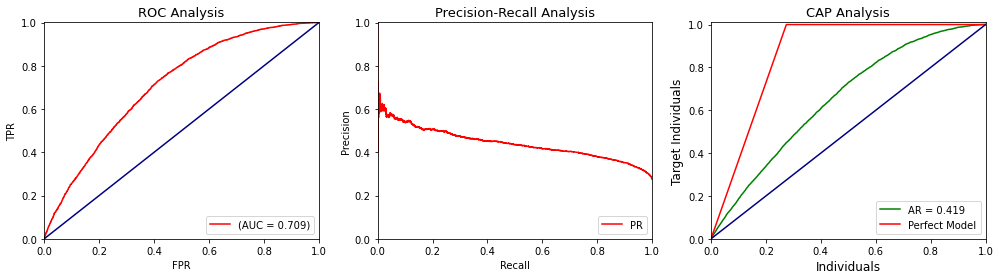

In [36]:
plot_classification_evaluation(
    df_test.loc[:, "responded_customer"],
    df_test.loc[:, "response_probability"]
)

_____
Conversion rate is defined as the percentage of users who have completed an offer. Our goal is to predict the probability of a user taking up an offer, hence the business shows success when the **conversion rate increases**. The project development is successful when there is a **lift** of conversion rate when using our model.

### 6.1. Conversion Rate (cumulative)

From the below analysis it is evident that there is an improvement in global conversion rate.

In [37]:
conversion_rate_bmk = df_test.loc[:, "responded_customer"].mean()
conversion_rate_model = df_test.loc[(df_test.response_prediction == 1), "responded_customer"].mean()
overall_lift = conversion_rate_model / conversion_rate_bmk

In [38]:
print(f"Cumulative Benchmark Conversion Rate: {100*conversion_rate_bmk:.2f}%")
print(f"Cumulative Model Conversion Rate: {100*conversion_rate_model:.2f}%")
print(f"Cumulative lift: {overall_lift:.2f}")

Cumulative Benchmark Conversion Rate: 27.41%
Cumulative Model Conversion Rate: 44.38%
Cumulative lift: 1.62


### 6.2. Conversion Rate (by Promotional Offer)

In order to obtain success in business and an increase in revenue, we will also calculate the conversion rate for each promotional offer. This can help business to focus on that particular offer.

In [39]:
lift_per_offer = (df_test.loc[:, ["offer", "responded_customer"]].groupby("offer").mean().reset_index())
model_results = (df_test.loc[(df_test.response_prediction == 1), ["offer", "responded_customer"]].groupby("offer").mean()
           .reset_index())

In [40]:
lift_per_offer.loc[:, "model_response"] = model_results.loc[:, "responded_customer"]
lift_per_offer.loc[:, "lift"] = lift_per_offer.loc[:, "model_response"] / lift_per_offer.loc[:, "responded_customer"]
lift_per_offer.sort_values(by="lift", ascending=False)

,offer,responded_customer,model_response,lift
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.142671,0.299065,2.096189
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.194481,0.358491,1.843320
7,ae264e3637204a6fb9bb56bc8210ddfd,0.219401,0.372308,1.696928
3,3f207df678b143eea3cee63160fa8bed,0.262252,0.439716,1.676696
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.218978,0.343643,1.569301
2,2906b810c7d4411798c6938adc9daaa5,0.206092,0.321678,1.560848
8,f19421c1d4aa40978ebb69ca19b0e20d,0.289387,0.397985,1.375269
5,5a8bc65990b245e5a138643cd4eb9837,0.443648,0.568330,1.281037
9,fafdcd668e3743c1bb461111dcafc2a4,0.399342,0.465817,1.166461
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.367608,0.422475,1.149256


<AxesSubplot:ylabel='offer'>

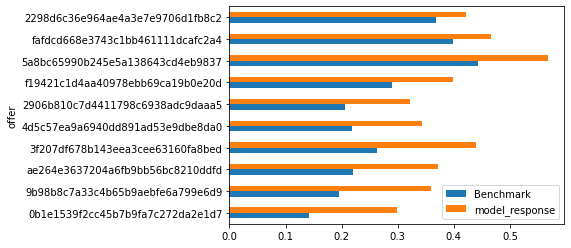

In [41]:
(lift_per_offer.sort_values(by="lift", ascending=False)
           .iloc[:, :-1]
           .set_index("offer")
           .rename(columns={"responded_customer": "Benchmark","": "model_response"}
           )
           .plot(kind="barh")
)

#### Conclusion

From the results drawn, it can be seen that the **cumulative model conversion rate achieved is higher than the benchmark** - which in fact is **almost twice** the benchmark conversion rate.
* Cumulative Benchmark Conversion Rate: 27.41%
* Cumulative Model Conversion Rate: 44.38%
* Cumulative lift: 1.62

Also, we could notice that the conversion rate segregated by offer achieved a **maximum lift of 2.096 and a minimum lift of 1.149**.

Hence we could conclude that the model was able to obtain an increase in conversion rate. This shall **benefit the business**, in terms of sending personalized promotional offers to targeted customers **with minimum resource utilization** and **marketing efforts**.

In [42]:
predictor.delete_endpoint()